In [1]:
from photochem import __version__
print(__version__)

0.6.2


# Tutorial

First, you need to install `Photochem` on your computer. Instructions are on the Photochem [README.md](https://github.com/Nicholaswogan/Photochem/blob/main/README.md). Then you can import it.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from photochem import EvoAtmosphere, zahnle_earth

Start by initializing an `EvoAtmosphere`. This requires several input files. Here, we use settings for the modern Earth atmosphere.

In [3]:
# Reactions
reaction_file = zahnle_earth 
# Various settings and boundary conditions
settings_file = "ModernEarth/settings.yaml" 
# Star
star_file = "ModernEarth/Sun_now.txt" 
# Initial conditions and eddy diffusion and temperature profile
atmosphere_file = "ModernEarth/atmosphere.txt"

pc = EvoAtmosphere(reaction_file,
                   settings_file,
                   star_file,
                   atmosphere_file)
pc.var.verbose = 0

## Understanding an `EvoAtmosphere` object

Once initialized, a `EvoAtmosphere` object contains a complete description of the atmosphere and the input chemistry and settings. Information is mainly stored in three objects within `EvoAtmosphere`

- `EvoAtmosphere.dat` is a `PhotochemData` object, holding information that can not change (with few exceptions) after initialization. For example, the reactions can not change
- `EvoAtmosphere.var` is a `PhotochemVars` object, holding information that can change between different photochemical integrations (with few exceptions), such a steady-state convergence criteria.
- `EvoAtmosphere.dat` is a `PhotochemWrkEvo` object, holding information that can change at each time step of integration.

We can call `help` on any variable to understand its meaning. Here are some examples:

In [4]:
from photochem._photochem import PhotochemData, PhotochemVars, PhotochemWrkEvo

In [5]:
help(PhotochemData.species_names)
# Print first couple species
print(pc.dat.species_names[:3])

Help on getset descriptor _photochem.PhotochemData.species_names:

species_names
    List, shape (nsp+2). A list of the species in the model (particles and gases).
    The last two elements are 'hv' and 'M'.

['H2Oaer', 'CO2aer', 'S8aer']


In [6]:
help(PhotochemWrkEvo.usol)

# Print current ground level number density of N2
ind = pc.dat.species_names.index('N2')
print('%e'%pc.wrk.usol[ind,0])

Help on getset descriptor _photochem.PhotochemWrk.usol:

usol
    ndarray[double,dim=2], shape (nq,nz). Current gas concentrations in the atmosphere.
    Units are mixing ratios for `Atmosphere` and molecules/cm^3 for `EvoAtmosphere`.

1.971736e+19


The `EvoAtmosphere` object also has lots of methods (i.e. functions) for acting upon the atmosphere, as demonstrated in the next couple sections

## Integrating an atmosphere forward in time

To integrate an atmosphere forward in time, you can use the `pc.initialize_robust_stepper` and `pc.robust_step` routine:

In [7]:
# Initialize an integrator with some initial conditions
initial_conditions = pc.wrk.usol
pc.initialize_robust_stepper(initial_conditions)

# Take a couple of integration steps
for i in range(5):
    give_up, converged = pc.robust_step()
    print('Current time in integration: %e s'%pc.wrk.tn)

Current time in integration: 1.000000e-06 s
Current time in integration: 3.151032e-05 s
Current time in integration: 3.366135e-04 s
Current time in integration: 3.119616e-03 s
Current time in integration: 2.169009e-02 s


The `pc.robust_step` method returns `give_up` and `converged`, which tell us whether we should give up and if the integration has converged to a steady state.

In [8]:
print(give_up)
print(converged)

False
False


We can integrate all the way to steady state with the function `pc.find_steady_state`. This function simply calls `pc.robust_step` until convergence or it is time to give up.

In [9]:
converged = pc.find_steady_state()
print(converged)

True


Now that we have reached a steady-state, we can plot the atmosphere's composition

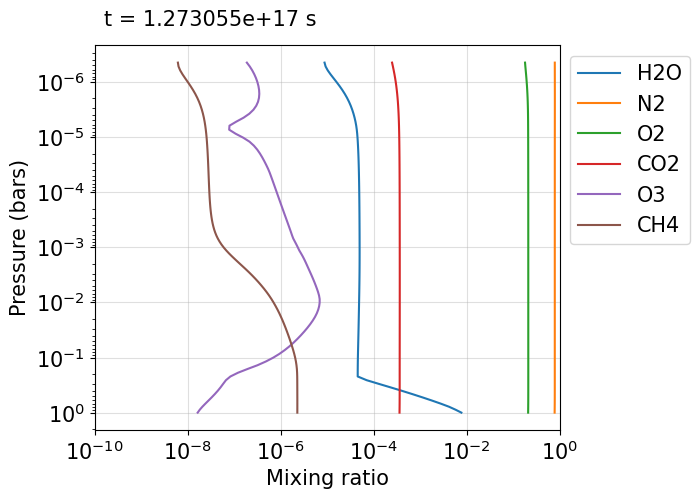

In [10]:
def plot_atmosphere(pc):
    plt.rcParams.update({'font.size': 15})
    fig,ax = plt.subplots(1,1,figsize=[6,5])
    
    # This function returns the state of the atmosphere in dictionary
    sol = pc.mole_fraction_dict()
    
    species = ['H2O','N2','O2','CO2','O3','CH4']
    for i,sp in enumerate(species):
        ax.plot(sol[sp], sol['pressure']/1e6, label=sp)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.grid(alpha=0.4)
    ax.set_xlim(1e-10,1)
    ax.set_ylabel('Pressure (bars)')
    ax.set_xlabel('Mixing ratio')
    ax.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    ax.text(0.02, 1.04, 't = '+'%e s'%pc.wrk.tn, \
        size = 15,ha='left', va='bottom',transform=ax.transAxes)
    
    plt.show()
plot_atmosphere(pc)

Currently, the boundary condition for CH$_4$ is fixed partial pressure. Below I change it to a flux boundary condition, and integrate to a new equilibrium, plotting the new methane profile every few steps.

In [11]:
pc.set_lower_bc('CH4',bc_type='flux',flux=1e9)

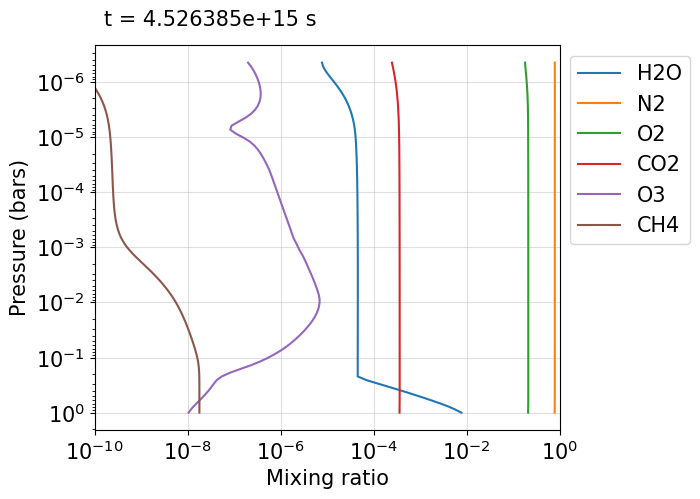

In [12]:
pc.initialize_robust_stepper(pc.wrk.usol) 
converged = False
while True:
    clear_output(wait=True)
    plot_atmosphere(pc)
    for i in range(10):
        give_up, converged = pc.robust_step()
        if give_up or converged:
            break
    if give_up or converged:
        break
        

We can compute the fluxes of gases into and out of the upper and lower boundary of the model to maintain steady-state.

In [13]:
surf, top = pc.gas_fluxes() # all in (molecules/cm2/s)
print(surf['CH4'])
print(top['H2'],top['H']) # hydrogen escape

999999975.8133956
108979722.69807994 1090736933.6598713


## Production and Loss of a species

We can analyze the production and loss of species like this

In [14]:
pl = pc.production_and_loss('CH4',pc.wrk.usol)
# all reactions that make CH4 sorted by importance. First is most important
print(pl.production_rx)

['H2O2 + CH3 => CH4 + HO2', 'HCl + CH3 => Cl + CH4', 'CH3 + H + M => CH4 + M', 'CH3 + OH => CH4 + O', 'CH3 + H2S => HS + CH4', 'CH3 + H2 => CH4 + H', 'CH3 + HNO => CH4 + NO', 'HS + CH3 => S + CH4', 'CH3CHO + hv => CH4 + CO', 'CH3 + H2O => CH4 + OH', 'CH3 + H2CO => CH4 + HCO', 'CH3 + HCO => CH4 + CO', 'C2H6 + hv => CH4 + 1CH2', 'CH3OH + CH3 => CH4 + CH3O', 'CH3 + CH3OH => H2COH + CH4', 'H2CN + CH3 => HCN + CH4', 'CH3O2 + H => CH4 + O2', 'CH3CO + CH3 => CH4 + CH2CO', 'NH + CH3 => N + CH4', 'CH3 + C2H5 => C2H4 + CH4', 'CH3CN + OH => CH4 + NCO', 'CH3 + CH3 => 1CH2 + CH4', 'CH3 + CH3 => CH2 + CH4', 'CH3 + C2H6 => C2H5 + CH4', 'CH3 + C2H3 => C2H2 + CH4', 'HCN + CH3 => CN + CH4', 'CH3 + C2H4 => C2H3 + CH4', 'NH3 + CH3 => NH2 + CH4', 'HCS + CH3 => CS + CH4', 'H2COH + H => O1D + CH4', 'CH3 + OH => O1D + CH4', 'N2H3 + CH3 => N2H2 + CH4', 'C3H6 + hv => C2H2 + CH4', 'NH + CH3 => N2D + CH4', 'N2H4 + CH3 => N2H3 + CH4', 'C2H2 + CH3 => C2H + CH4', 'C2H + CH3 => C2 + CH4', 'C2H4 + H => CH + CH4', 'H2C

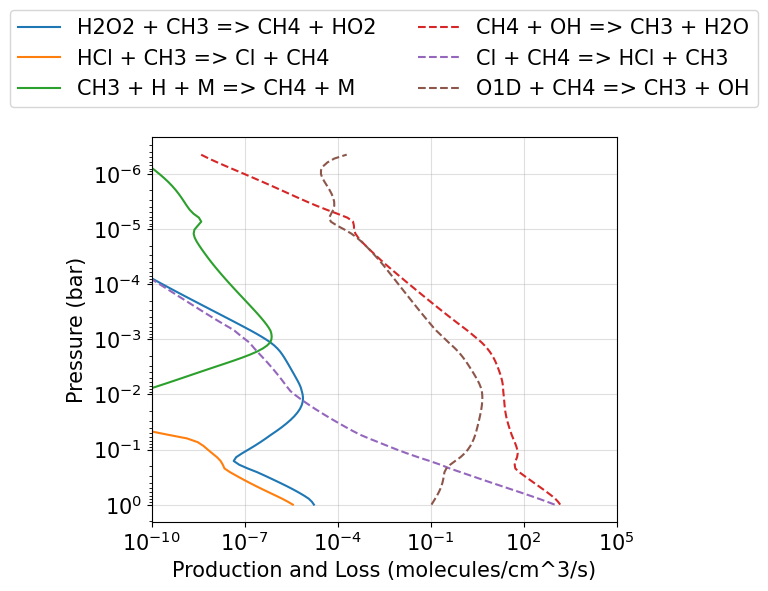

In [15]:
sol = pc.mole_fraction_dict()

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[6,5])

for i in range(3):
    ax.plot(pl.production[:,i],sol['pressure']/1e6,label=pl.production_rx[i])
    
for i in range(3):
    ax.plot(pl.loss[:,i],sol['pressure']/1e6,'--',label=pl.loss_rx[i])

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid(alpha=0.4)
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Production and Loss (molecules/cm^3/s)')
ax.set_xlim(1e-10,1e5)
ax.legend(ncol=2,bbox_to_anchor=(0.5,1.05),loc='lower center')
plt.show()

Chemical production and loss are matched mostly by surface fluxes. This does not include chemical rainout, which explains why they are slightly different.

In [16]:
net = np.sum(pl.integrated_production) - np.sum(pl.integrated_loss)
print(net)
surf, top = pc.gas_fluxes()
print(surf['CH4'])

-999999422.3694289
999999975.8133956


At any point, you can output the atmosphere to a file using `pc.out2atmosphere_txt`. The model can be reinitialized from this file.

/var/folders/sf/43vm953d201c4jw4yg22hnhc0000gn/T/ipykernel_99578/1233761966.py:6: RuntimeWarning: invalid value encountered in divide
  sol = pc.mole_fraction_dict()


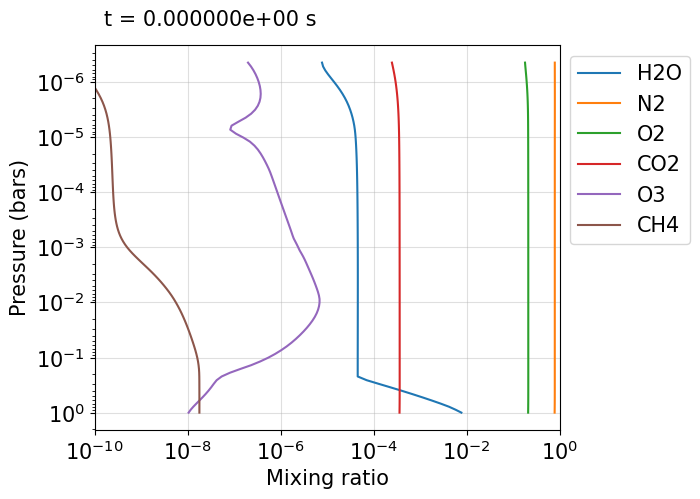

In [17]:
# Write output file
pc.out2atmosphere_txt('out.txt',overwrite=True)

# Reinitialize using outputfile
pc = EvoAtmosphere(reaction_file,
                   settings_file,
                   star_file,
                   'out.txt')
pc.var.verbose = 0

plot_atmosphere(pc)